In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.layers import Dense, LSTM
from keras.models import Sequential
from matplotlib.colors import LinearSegmentedColormap

In [4]:
df=pd.read_csv("netflix_titles.csv") # taking input into a dataframe

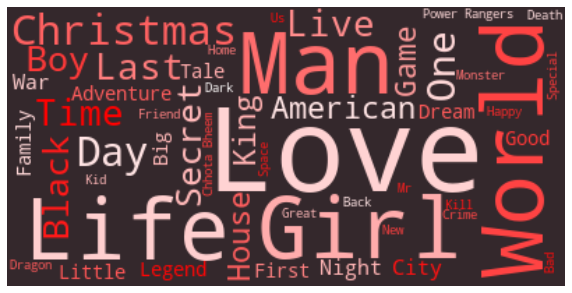

In [5]:
#Creating a word cloud from the movie titles
!pip install wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(name for name in df.title)

stopwords = set(STOPWORDS)
stopwords.update(["de", "El", "show","Story","La",'Movie'])
colors = ["white", "red"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
wordcloud = WordCloud( max_words=50, background_color='#34282C', stopwords=stopwords, colormap=cmap).generate(text)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:

df = df[df['date_added'].notna()]# removing all rows that do not mention the date
df['date_added']= pd.to_datetime(df['date_added']) # converting the date_added column to type datetime
df['date_added']=df['date_added'].dt.to_period('M')#extracting only the year and month from the date_added column
df=df[df['date_added']>='2015-01']# we're going to consider records since the year of 2015 for this prediction process
df=df.sort_values(by='date_added')
df_count=df.groupby("date_added")['show_id'].count()#getting total number of movies by month
month_counts=df_count.values# list of total number of movies released every month between 2015 Jan to 2021 Sept



In [7]:
df.describe(include='all') 

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
count,8741,8741,8741,6128,7921,7911,8741,8741.000000,8737,8738,8741,8741
unique,8741,2,8738,4494,7637,742,81,NaN,17,220,512,8709
top,s5920,Movie,15-Aug,Rajiv Chilaka,David Attenborough,United States,2021-07,NaN,TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,1,6086,2,19,19,2771,257,NaN,3183,1790,360,4
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.236129,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.784899,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.000000,NaN,NaN,NaN,NaN


In [8]:
# splitting the sequence of total movies into training and testing
def split_series(t_series, lookback, prediction_horizon):
  X, y= list(), list()
  for i in range(len(t_series)):
    end_ip = i+ lookback # end of input
    end_op = end_ip+prediction_horizon
    if end_op>len(t_series):
      break
    seq_x, seq_y = t_series[i:end_ip], t_series[end_ip:end_op]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [9]:
# checking model perforamnce by predictng results for the last 9 months that is from Jan 2021 to Sept 2021 and comparing against actual values
n_steps = 12
n_features = 1
X_train = month_counts[:-12-9]
X_test = month_counts[-12-9:]
y_test=month_counts[-9:]
prediction_horizon=9

X,y= split_series(X_train, n_steps, prediction_horizon) # preparing inputs
X = X.reshape((X.shape[0], X.shape[1], 1)) #reshaing inputs

  # LSTM model definition
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(prediction_horizon))
model.compile(optimizer='Adam', loss='mse')
model.fit(X, y, epochs=50, verbose=1)
X_test=X_test[:-prediction_horizon].reshape((1, n_steps, n_features))
y_pred=model.predict(X_test)

  #RMSE calculations
RMSE_LSTM = np.sqrt(sum((np.array(y_test) - np.array(y_pred[0]))**2)/len(y_test))



Epoch 1/50
2/2 [==============================] - 6s 48ms/step - loss: 16463.4277
Epoch 2/50
2/2 [==============================] - 0s 37ms/step - loss: 13525.6328
Epoch 3/50
2/2 [==============================] - 0s 36ms/step - loss: 12404.1689
Epoch 4/50
2/2 [==============================] - 0s 32ms/step - loss: 10865.3789
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 8864.9170
Epoch 6/50
2/2 [==============================] - 0s 37ms/step - loss: 6698.4658
Epoch 7/50
2/2 [==============================] - 0s 47ms/step - loss: 4671.7573
Epoch 8/50
2/2 [==============================] - 0s 44ms/step - loss: 3409.0085
Epoch 9/50
2/2 [==============================] - 0s 38ms/step - loss: 2743.9753
Epoch 10/50
2/2 [==============================] - 0s 32ms/step - loss: 1882.5422
Epoch 11/50
2/2 [==============================] - 0s 33ms/step - loss: 1453.1362
Epoch 12/50
2/2 [==============================] - 0s 42ms/step - loss: 1050.3241
Epoch 13/50
2/2 [====

In [10]:
RMSE_LSTM

63.65920236715925

In [11]:
# Actual prediction for the next 9 months
X=month_counts
X,y= split_series(X_train, n_steps, prediction_horizon) # preparing inputs
X = X.reshape((X.shape[0], X.shape[1], 1))
X_test = month_counts[-12:]
model.fit(X, y, epochs=50, verbose=1)
X_test=X_test.reshape((1, n_steps, n_features))
y_pred=model.predict(X_test)

Epoch 1/50
2/2 [==============================] - 0s 34ms/step - loss: 536.1304
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 501.7036
Epoch 3/50
2/2 [==============================] - 0s 36ms/step - loss: 547.9388
Epoch 4/50
2/2 [==============================] - 0s 30ms/step - loss: 530.8619
Epoch 5/50
2/2 [==============================] - 0s 39ms/step - loss: 538.7776
Epoch 6/50
2/2 [==============================] - 0s 38ms/step - loss: 514.2720
Epoch 7/50
2/2 [==============================] - 0s 50ms/step - loss: 507.5011
Epoch 8/50
2/2 [==============================] - 0s 26ms/step - loss: 499.3330
Epoch 9/50
2/2 [==============================] - 0s 21ms/step - loss: 543.9647
Epoch 10/50
2/2 [==============================] - 0s 28ms/step - loss: 505.2905
Epoch 11/50
2/2 [==============================] - 0s 24ms/step - loss: 521.2451
Epoch 12/50
2/2 [==============================] - 0s 41ms/step - loss: 496.1882
Epoch 13/50
2/2 [====================

In [12]:
print(RMSE_LSTM)

63.65920236715925


In [13]:
print(y_pred)
res=[round(i) for i in y_pred[0].tolist()]
new_months=month_counts.tolist()
new_months.extend(res)


[[189.24213 194.83234 212.81718 170.43048 180.48674 160.2203  198.18391
  181.60338 180.30894]]


In [14]:
n=['2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04','2022-05','2022-06'] #next months to be predicted

In [15]:
dates=df_count.index
dates=(dates.astype(str)).tolist()
dates.extend(n)


Text(0.5, 1.0, 'Prediction of the number of movies that Netflix is going to release in the future')

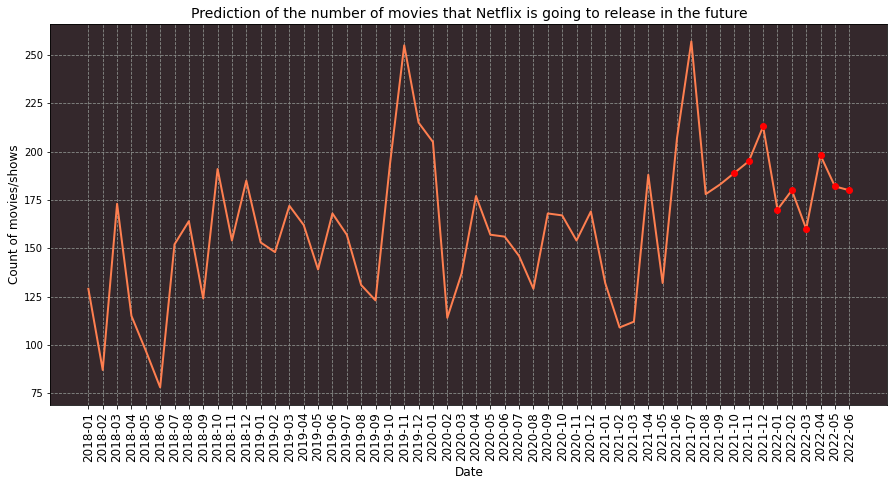

In [17]:
plt.figure(figsize=(15,7))
ax = plt.axes()
ax.set_facecolor("#34282C")

plt.grid(color='#8D918D',linestyle = '--', which='major')
plt.plot(dates[-54:], new_months[-54:], color='#FF7F50', linewidth=2)
plt.plot(n, res, 'ro')
plt.xticks(rotation=90,fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count of movies/shows",fontsize=12)
plt.title("Prediction of the number of movies that Netflix is going to release in the future",fontsize=14)